In [1]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay, fowlkes_mallows_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Read in CSV Data
dataset = pd.read_csv('./data/creditcard.csv')
display(dataset.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
"""
Preprocessing steps
1. Shuffle the dataset
2. Separate the labels from the data
3. Normalize the data via MinMaxScalar
"""
# Shuffling the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Separating the labels from the data
labels = dataset['Class']
unsupervised_data = dataset.drop(columns=['Class'])

# Normalizing by Min/Max Scalar
unsupervised_data = MinMaxScaler(feature_range=(0, 1)).fit_transform(unsupervised_data)

In [32]:
"""
Utility functions for generating models and getting results
"""
### Util functions to train models ###
def get_trained_model(x_train: np.ndarray, num_iterations: int) -> GaussianMixture:
    gmm = GaussianMixture(n_components=2, n_init=num_iterations)
    return gmm.fit(x_train)

def get_train_test_splits(X: np.ndarray, Y: np.ndarray, train_index: np.ndarray, test_index: np.ndarray) -> tuple:
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    return x_train, x_test, y_train, y_test

def get_model_predictions(model: GaussianMixture, x_test: np.ndarray, y_test: np.ndarray):
    predictions = model.predict(x_test)
    return x_test, y_test, predictions

### Util functions for displaying results
def get_confusion_matrices(results: list) -> list:
    matrices_of_confusion = []
    for i, (x_test, ground_truth, prediction) in enumerate(results):
        cm = confusion_matrix(ground_truth, prediction)
        if cm[0][0] < cm[0][1]:
            print("matrix switch")
            results[i] = (x_test, ground_truth, 1 - prediction)
            cm = confusion_matrix(ground_truth, 1 - prediction)
        matrices_of_confusion.append(cm)
    return matrices_of_confusion

def get_recall_rates(matrices_of_confusion: list) -> list:
    recall_rates = []
    for confusion_matrix in matrices_of_confusion:
        recall = confusion_matrix[1][1] / (np.sum(confusion_matrix[1]))
        recall_rates.append(recall)
    return recall_rates

def get_accuracies(results: list) -> list:
    accuracies = []
    for _, y_test, prediction in results:
        accuracy = np.count_nonzero(y_test == prediction) / len(y_test)
        accuracies.append(accuracy)
    return accuracies

def get_silhouette_scores(results: list) -> list:
    scores = []
    for x_test, _, prediction in results:
        score = silhouette_score(x_test, prediction)
        scores.append(score)
    return scores

def get_fowlkes_mallows_scores(results: list) -> list:
    scores = []
    for _, ground_truth, prediction in results:
        score = fowlkes_mallows_score(ground_truth, prediction)
        scores.append(score)
    return scores

def plot_clusterings(results: list) -> None:
    for count, (x_test, y_test, prediction_test) in enumerate(results):
        colors = {
            0: "green",
            1: "red"
        }
        for group in np.unique(y_test):
            indexes = np.where(group == prediction_test)
            plt.scatter(
                x_test[indexes, 1],
                x_test[indexes, 2],
                c=colors[group],
                s=5,
                label=group,
            )
        plt.title(f"Visualization of Clusterings using V1 and V2 for k={count + 1}")    
        plt.legend()
        plt.show()

In [6]:
# With basic K_Fold Validation (5 folds)
K_FOLDS = 5
NUM_ITERATIONS = 10

results = []
count = 0
for train_index, test_index in KFold(shuffle=True, n_splits=K_FOLDS).split(unsupervised_data):
    count += 1
    print(f'Running fold # {count}')

    # Splitting data and obtaining trained model
    print("Splitting Data")
    x_train, x_test, _, y_test = get_train_test_splits(unsupervised_data, labels, train_index, test_index)
    
    # Training Model
    print("Training Model")
    model = get_trained_model(x_train, NUM_ITERATIONS)

    # Get Test Results for Models
    print("Testing and Obtaining Results")
    print()
    test_result = get_model_predictions(model, x_test, y_test)
    results.append(test_result)

Running fold # 1
Splitting Data
Training Model
Testing and Obtaining Results

Running fold # 2
Splitting Data
Training Model
Testing and Obtaining Results



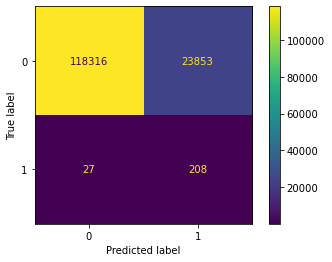

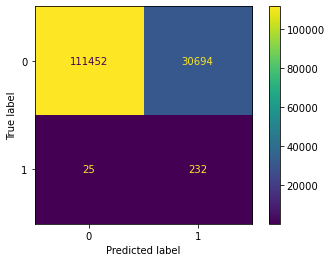

In [28]:
# Displaying Confusion Matrices
for matrix in get_confusion_matrices(results):
    ConfusionMatrixDisplay(matrix).plot()

In [ ]:
# Display other metrics
accuracies = get_accuracies(results)
recalls = get_recall_rates(get_confusion_matrices(results))
silhouette_scores = get_silhouette_scores(results)
fowlkes_mallows_scores = get_fowlkes_mallows_scores(results)

print(f'Overall accuracies: {accuracies}')
print(f'Overall recall rates: {recalls}')
print(f'Silhouette Scores: {silhouette_scores}')
print(f'Fowlkes Mallows Scores: {fowlkes_mallows_scores}')

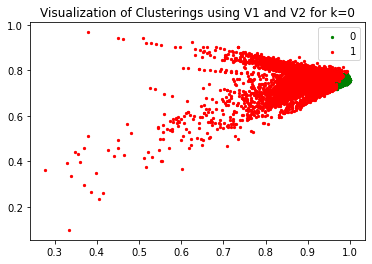

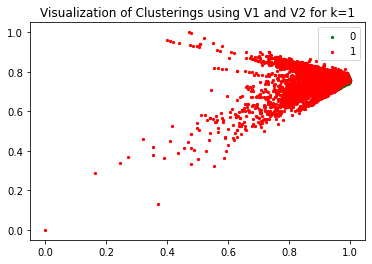

In [33]:
# Plotting Clusterings with respect to just V1 and V2
plot_clusterings(results)